# Projet Cross Asset - Gestion pilotée par horizon
### *Présenté par Timothée Dangleterre, Giovanni Manche, Cherine Rhellab et Edi Verbovci* 

In [55]:
import pandas as pd, numpy as np 
import matplotlib.pyplot as plt
from classes.portfolio import Portfolio
from classes.visualisation import Visualisation
from classes.metrics import Metrics
from classes.pilar import Pilar
from classes.grid import Grid
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)  
warnings.filterwarnings('ignore', category=DeprecationWarning) 

## 1. Optimisation de la grille équilibre

In [56]:
periodicity: str = "monthly"
rebalancing: str = "quarterly"
frequency: str = "yearly"
method: str = "discret"
calculation_window:int = 6

### 1.1. Construction du pilier actions

Nous proposons de construire notre pilier actions en diversifiant de la manière suivante : 
- Une allocation "core" qui comprend les indices actions principaux de grands pays et émergents : SP500, EuroStoxx 50, Nikkei 225, MSCI Emerging Index. Cette allocation vise principalement à récupérer le $\beta$ de marché.
- Une allocation "Momentum", basé sur la stratégie du même nom, qui contiendra des indices plus exotiques avec un double objectif : diversifier notre pilier et chercher un peu d'$\alpha$.

Chaque membre de notre pilier se verra allouer une allocation minimale, et on cherchera alors à minimiser la variance.

#### 1.1.1. Construction de la poche Momentum

Nous construisons d'abord un portefeuille Momentum sur la base des rendements cumulés mensuels, avec un rebalancement trimestriel. Le calcul des signaux est fait sur une fenêtre semestrielle. On distingue d'abord les indices core des autres, puis on créé un portefeuille Momentum sur la base des autres indices.

In [58]:
core_stock_indices = ["SPX Index", "SX5E Index", "NKY Index"]
all_stock_prices = pd.read_excel("data/Inputs v2.xlsx", sheet_name= "Actions").set_index("Date")
# Gestion des NA par interpolation
cols_with_na = [col for col in all_stock_prices.columns if all_stock_prices[col].isnull().sum() != 0]
all_stock_prices[cols_with_na] = all_stock_prices[cols_with_na].interpolate(method = 'linear')

core_stock_prices = all_stock_prices[core_stock_indices]
not_core_prices = all_stock_prices.loc[:, ~all_stock_prices.columns.isin(core_stock_indices)]

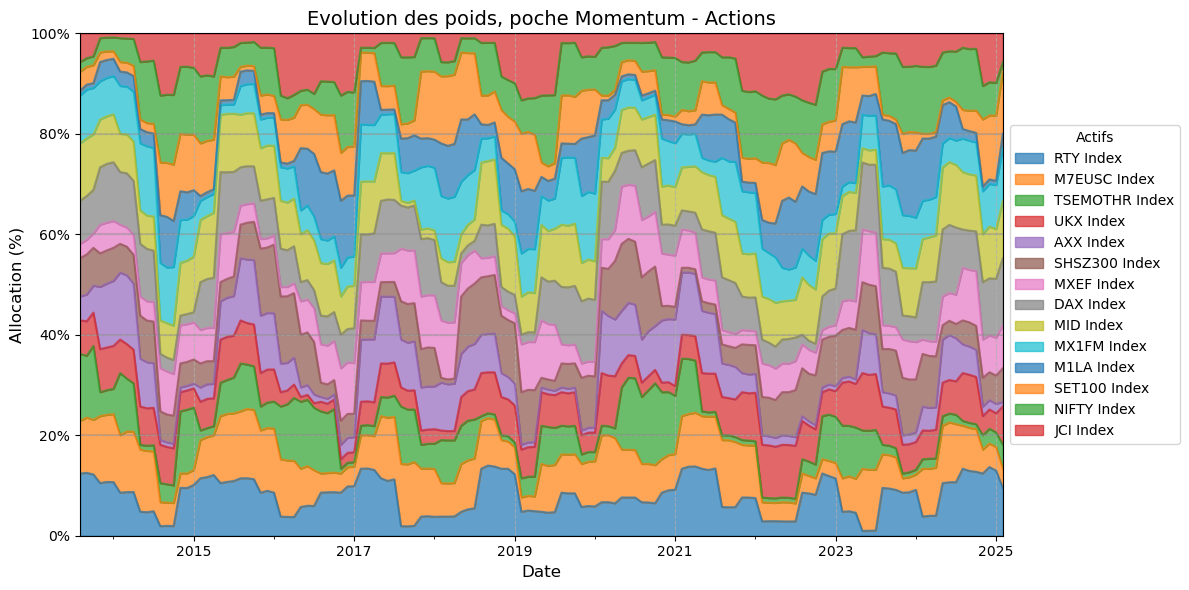

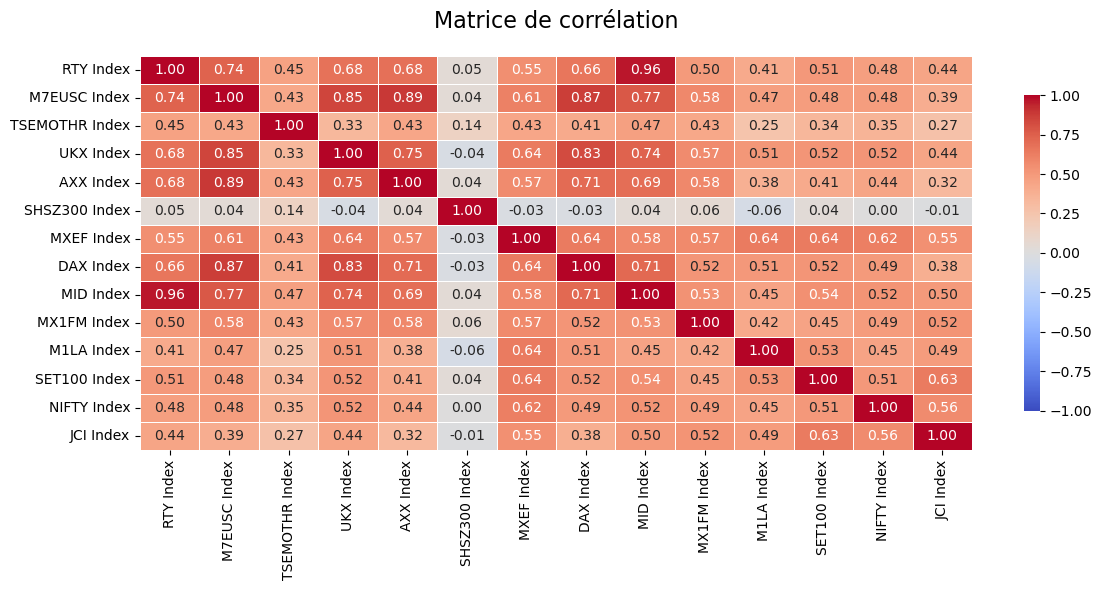

In [59]:
list_strategy = ["momentum"]
list_weighting = ["ranking"]
momentum_stock_portfolio = Portfolio(not_core_prices, periodicity = periodicity,
                                 rebalancement= rebalancing, method="discret", list_strat=list_strategy, list_weighting=list_weighting,
                                 calculation_window=6, asset_class="equity")
momentum_stock_portfolio.run_backtest()
Visualisation.plot_weights(momentum_stock_portfolio.positions, 
                           title = "Evolution des poids, poche Momentum - Actions")
Visualisation.heatmap_correlation(momentum_stock_portfolio.returns["monthly"])

On affiche quelques métriques pour le portefeuille Momentum à partir de 2015.

In [60]:
considered_momentum = momentum_stock_portfolio.portfolio_value[momentum_stock_portfolio.portfolio_value.index >= '2015-01-01']
bench: pd.DataFrame = momentum_stock_portfolio.benchmark.iloc[calculation_window:,].iloc[:,0].copy()
bench = bench[bench.index >= '2015-01-01']
metrics_action:Metrics = Metrics(considered_momentum, 
                                 method =method, frequency=frequency, benchmark=bench)
print("Synthèse pour le portefeuille momentum action : ")
premia_equity: float = metrics_action.synthesis()

Synthèse pour le portefeuille momentum action : 
Statistiques pour le portefeuille : 
Rendement annualisé du portefeuille (en %) : 3.61.
Volatilité annualisée du portefeuille (en %) : 9.67.
Sharpe ratio du portefeuille : 0.17.
Total return du portefeuille (en %) : 47.71
Statistiques pour le benchmark  :
Rendement annualisé du benchmark (en %) : 6.24.
Volatilité annualisée du benchmark (en %) : 16.3.
Sharpe ratio du benchmark : 0.26.
Total return du benchmark (en %) : 94.51
La prime de diversification s'élève à -9.34 % pour chaque point de volatilité supplémentaire pris


#### 1.1.2. Répartition core - momentum

Pour répartir notre allocation entre les différents éléments, on va : 
- imposer des poids minimaux pour chaque membre du pilier (SP500, Stoxx 50, Nikkei 225, MSCI EM, Momentum)
- minimiser la variance.

In [61]:
momentum_stock_portfolio.portfolio_value.name = "Momentum Ptf Value"
# Rmq : comme momentum_stock_portfolio.portfolio_value est déjà en monthly, 
# pilar_member_prices va automatiquement récupérer les prix mensuels aux bonnes dates. 
pilar_member_prices = core_stock_prices.join(momentum_stock_portfolio.portfolio_value, how='inner')

In [62]:
stock_pilar = Pilar(asset_prices=pilar_member_prices,
                    periodicity="monthly", method="discret")
minimal_weights_constraints = {
    "SPX Index": 0.2,
    "SX5E Index": 0.3,
    "NKY Index": 0.1,
    "Momentum Ptf Value": 0.2
}


In [63]:
stock_weights, stock_returns = stock_pilar.run_min_variance_optimization(
    calculation_window=calculation_window, rebalancing_freq=rebalancing,
    min_weights=minimal_weights_constraints)

<Axes: title={'center': 'Évolution des poids du portefeuille'}, xlabel='Date', ylabel='Allocation (%)'>

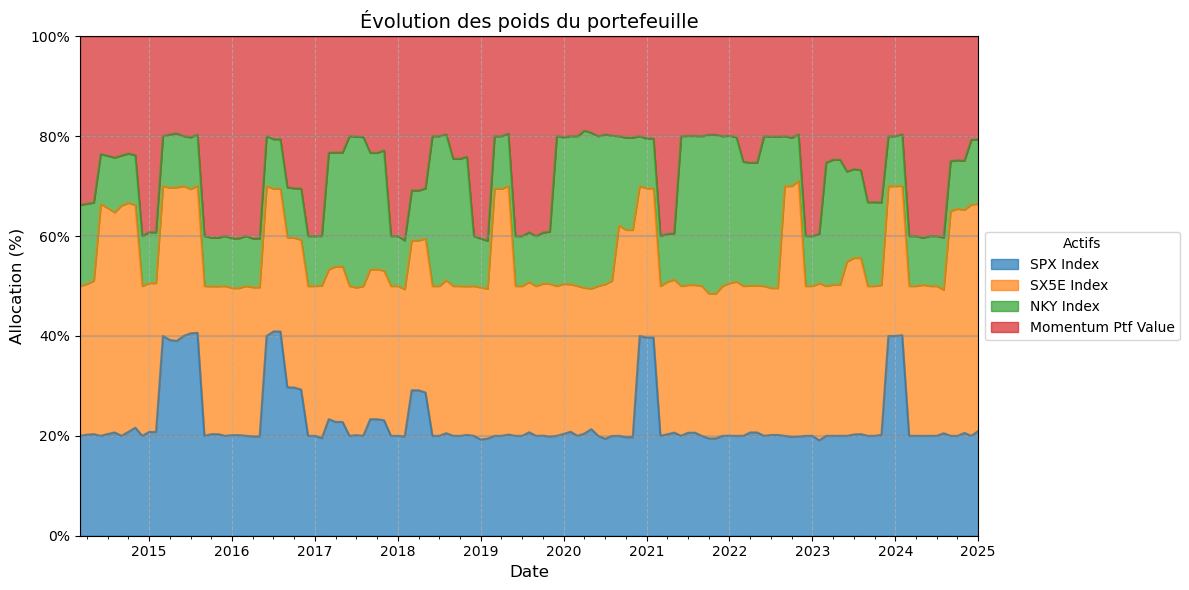

In [64]:
Visualisation.plot_weights(stock_weights)

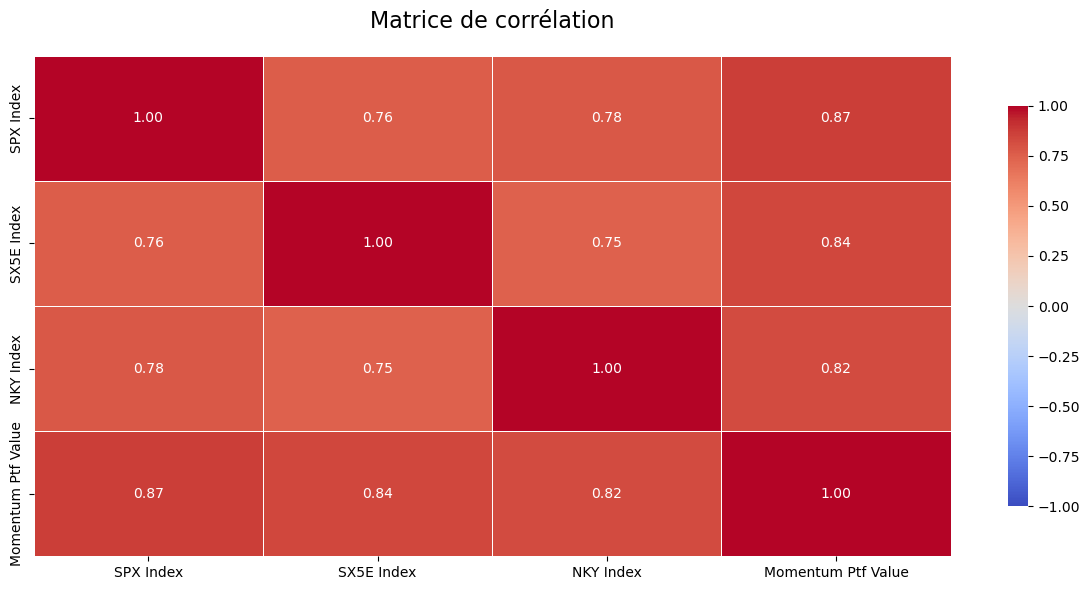

In [65]:
Visualisation.heatmap_correlation(stock_pilar.returns)

In [66]:
stock_pilar_value = stock_pilar.compute_pilar_value(stock_weights)
considered_stock_pilar_value = stock_pilar_value[stock_pilar_value.index >='2015-01-01']
metrics_action:Metrics = Metrics(considered_stock_pilar_value, 
                                 method =method, frequency=frequency, benchmark=bench)
print("Synthèse pour le pilier action : ")
premia_equity: float = metrics_action.synthesis()

Synthèse pour le pilier action : 
Statistiques pour le portefeuille : 
Rendement annualisé du portefeuille (en %) : 7.09.
Volatilité annualisée du portefeuille (en %) : 9.38.
Sharpe ratio du portefeuille : 0.54.
Total return du portefeuille (en %) : 112.38
Statistiques pour le benchmark  :
Rendement annualisé du benchmark (en %) : 6.24.
Volatilité annualisée du benchmark (en %) : 23.53.
Sharpe ratio du benchmark : 0.18.
Total return du benchmark (en %) : 94.51
La prime de diversification s'élève à 36.22 % pour chaque point de volatilité supplémentaire pris


### 1.2. Construction du pilier obligataire

La procédure suivie est la même que pour le pilier actions.

#### 1.2.1. Construction de la poche Momentum

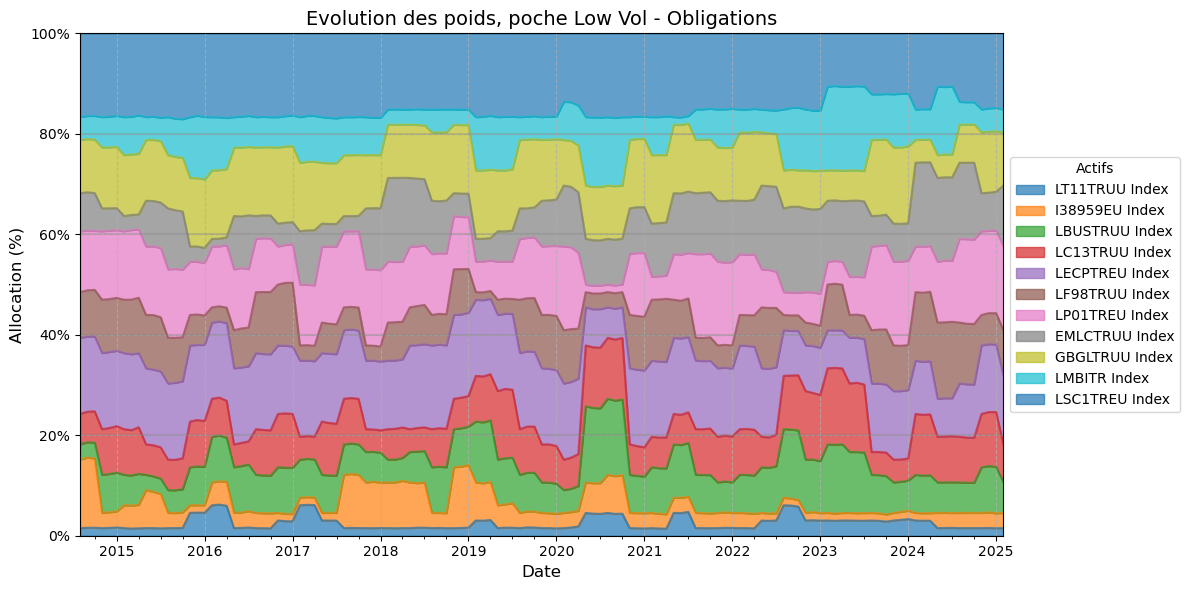

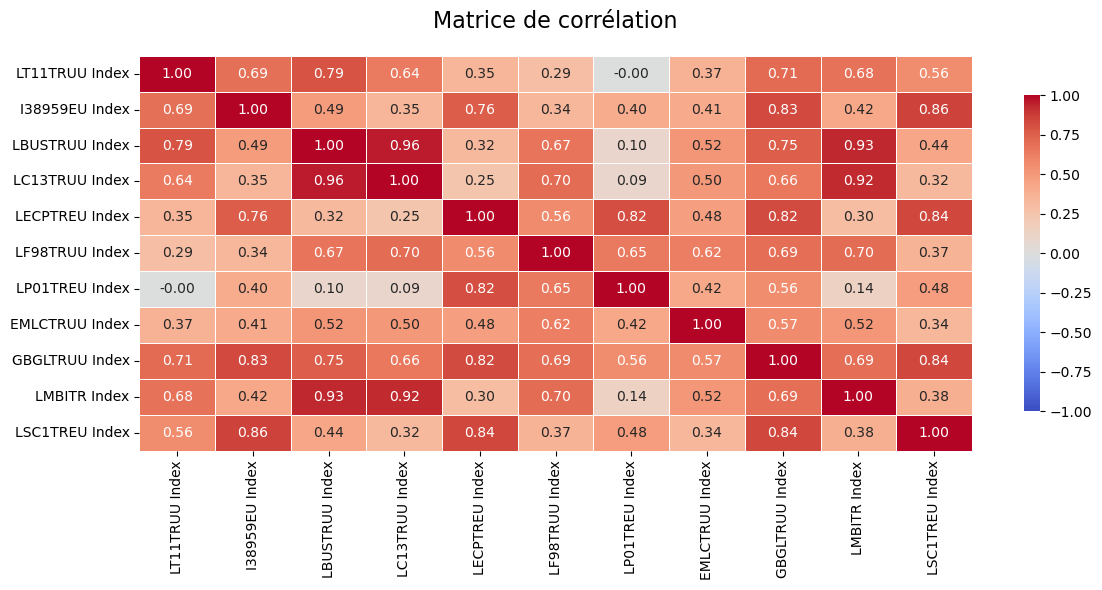

Synthèse pour le portefeuille momentum obligations : 
Statistiques pour le portefeuille : 
Rendement annualisé du portefeuille (en %) : 1.48.
Volatilité annualisée du portefeuille (en %) : 5.65.
Sharpe ratio du portefeuille : -0.09.
Total return du portefeuille (en %) : 17.53
Statistiques pour le benchmark  :
Rendement annualisé du benchmark (en %) : 0.12.
Volatilité annualisée du benchmark (en %) : 34.62.
Sharpe ratio du benchmark : -0.05.
Total return du benchmark (en %) : 1.34
La prime de diversification s'élève à -3.79 % pour chaque point de volatilité supplémentaire pris


In [68]:
core_bond_indices = ["BTSYTRUU Index", "H16162US Index", "LEGATRUU Index"]
all_bond_prices = pd.read_excel("data/Inputs v2.xlsx", sheet_name= "Obligataire").set_index("Date")
# Gestion des NA par interpolation
cols_with_na = [col for col in all_bond_prices.columns if all_bond_prices[col].isnull().sum() != 0]
all_bond_prices[cols_with_na] = all_bond_prices[cols_with_na].interpolate(method = 'linear')

core_bond_prices = all_bond_prices[core_bond_indices]
not_core_bond_prices = all_bond_prices.loc[:, ~all_bond_prices.columns.isin(core_bond_indices)]
list_strategy = ["low vol"]
list_weighting = ["ranking"]
low_vol_bond_portfolio = Portfolio(not_core_bond_prices, periodicity = periodicity,
                                 rebalancement= rebalancing, method="discret", list_strat=list_strategy, list_weighting=list_weighting,
                                 calculation_window=6, asset_class="bonds")
low_vol_bond_portfolio.run_backtest()
Visualisation.plot_weights(low_vol_bond_portfolio.positions, 
                           title = "Evolution des poids, poche Low Vol - Obligations")
Visualisation.heatmap_correlation(low_vol_bond_portfolio.returns["monthly"])

considered_low_vol = low_vol_bond_portfolio.portfolio_value[low_vol_bond_portfolio.portfolio_value.index >= '2015-01-01']
bond_bench: pd.DataFrame = low_vol_bond_portfolio.benchmark.iloc[calculation_window:,].iloc[:,0].copy()
bond_bench = bond_bench[bond_bench.index >= '2015-01-01']

metrics_bond:Metrics = Metrics(considered_low_vol, 
                               method =method, frequency=frequency, benchmark=bond_bench)
print("Synthèse pour le portefeuille momentum obligations : ")
premia_bond: float = metrics_bond.synthesis()


#### 1.2.2. Répartition core - Momentum

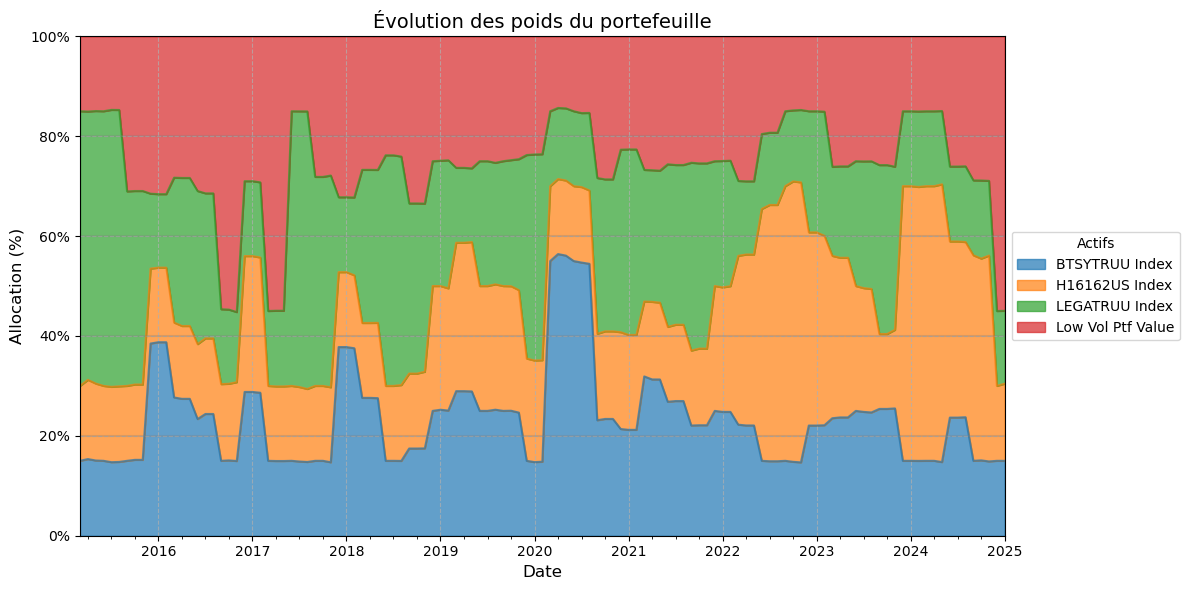

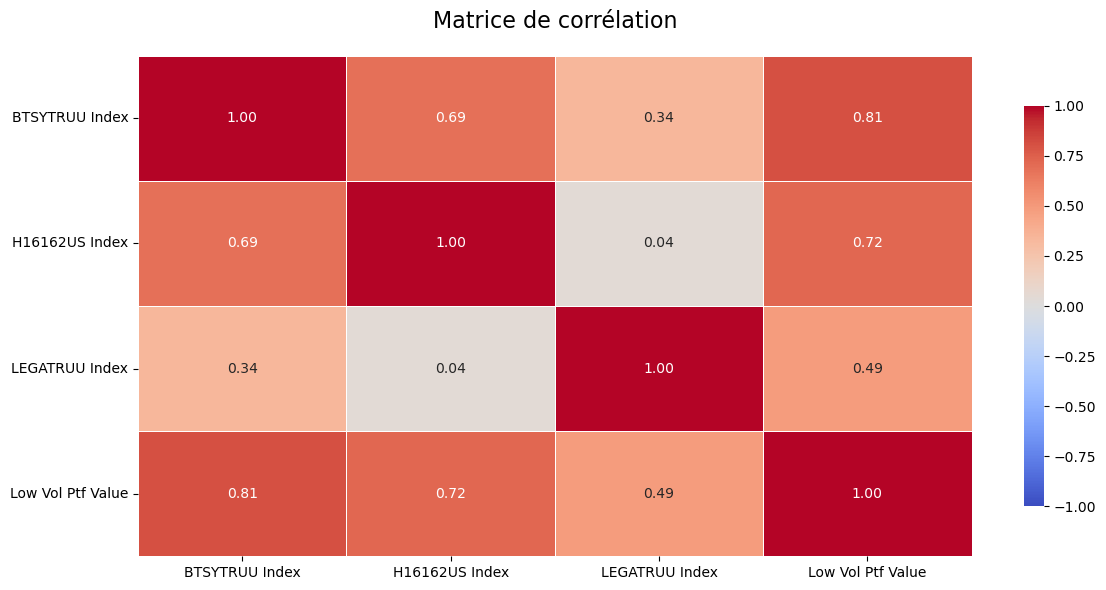

Synthèse pour le pilier obligation : 
Statistiques pour le portefeuille : 
Rendement annualisé du portefeuille (en %) : 1.27.
Volatilité annualisée du portefeuille (en %) : 4.74.
Sharpe ratio du portefeuille : -0.15.
Total return du portefeuille (en %) : 14.92
Statistiques pour le benchmark  :
Rendement annualisé du benchmark (en %) : 0.12.
Volatilité annualisée du benchmark (en %) : 40.33.
Sharpe ratio du benchmark : -0.05.
Total return du benchmark (en %) : 1.34
La prime de diversification s'élève à -10.69 % pour chaque point de volatilité supplémentaire pris


In [69]:
low_vol_bond_portfolio.portfolio_value.name = "Low Vol Ptf Value"
# Rmq : comme momentum_bond_portfolio.portfolio_value est déjà en monthly, 
# pilar_member_prices va automatiquement récupérer les prix mensuels aux bonnes dates. 
bond_pilar_member_prices = core_bond_prices.join(low_vol_bond_portfolio.portfolio_value, how='inner')
bond_pilar = Pilar(asset_prices=bond_pilar_member_prices,
                   periodicity="monthly", method="discret")
minimal_weights_constraints = {
    "BTSYTRUU Index": 0.15,
    "H16162US Index": 0.15,
    "LEGATRUU Index": 0.15, 
    "Low Vol Ptf Value": 0.15
}
bond_weights, bond_returns = bond_pilar.run_min_variance_optimization(
    calculation_window=calculation_window, rebalancing_freq=rebalancing,
    min_weights=minimal_weights_constraints)
Visualisation.plot_weights(bond_weights)
Visualisation.heatmap_correlation(bond_pilar.returns)


bond_pilar_value = bond_pilar.compute_pilar_value(bond_weights)
considered_bond_pilar_value = bond_pilar_value[bond_pilar_value.index >= '2015-01-01']
metrics_bond:Metrics = Metrics(considered_bond_pilar_value, 
                               method=method, frequency=frequency, benchmark=bond_bench)
print("Synthèse pour le pilier obligation : ")
premia_bond: float = metrics_bond.synthesis()


### 1.3. Pilier monétaire

In [48]:
# Import des données
data_monetaire = pd.read_excel("data/Inputs v2.xlsx", sheet_name= "Monétaire").set_index("Date")
cols_with_na = [col for col in data_monetaire.columns if data_monetaire[col].isnull().sum() != 0]
data_monetaire[cols_with_na] = data_monetaire[cols_with_na].interpolate(method = 'linear')

# Sur le monétaire : pas de stratégie particulière
ptf_monetaire: pd.Series = data_monetaire

# Affichage des métriques de performance du pilier monétaire
metrics_monetaire:Metrics = Metrics(ptf_monetaire, method=method, frequency=frequency)
print("Statistiques pour le pilier monétaire : ")
metrics_monetaire.display_stats()

Statistiques pour le pilier monétaire : 
Rendement annualisé du portefeuille (en %) : OISESTR Index    0.42
dtype: float64.
Volatilité annualisée du portefeuille (en %) : OISESTR Index    1.49
dtype: float64.
Sharpe ratio du portefeuille : OISESTR Index   -1.06
dtype: float64.
Total return du portefeuille (en %) : OISESTR Index    4.72
dtype: float64


### 1.4. Optimisation de la grille sous contrainte de CVaR

#### 1.4.1. Etude de la grille initiale

<Axes: title={'center': 'Evolution de la CVaR : grille initiale'}, xlabel='Horizon avant la retraite (années)', ylabel='CVaR'>

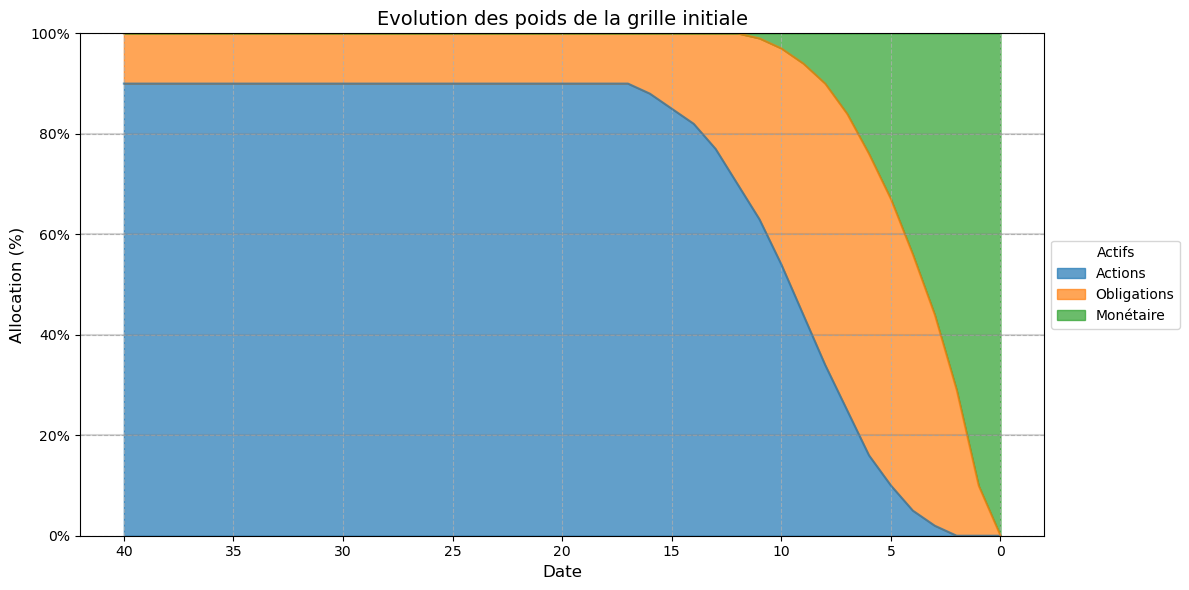

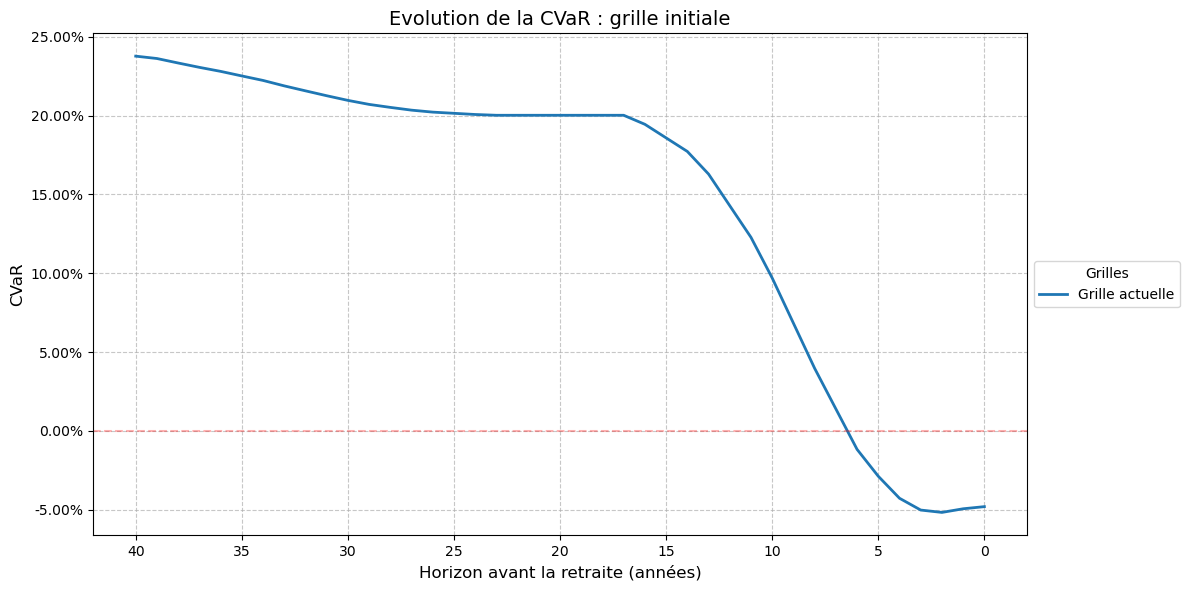

In [49]:
initial_grid_weights = pd.read_excel("data/Inputs v2.xlsx", sheet_name= "Grille initiale").set_index("Horizon")
# On calcule les rendements via la méthode de Pilar
initial_assets = pd.concat([all_stock_prices["MSDEE15N Index"], all_bond_prices["LBEATREU Index"], data_monetaire["OISESTR Index"]], axis = 1).dropna()
initial_returns = Pilar(asset_prices=initial_assets, periodicity=periodicity, method = method).compute_asset_returns(periodicity)
initial_grid = Grid(
    long_term_returns=[0.06, 0.035, 0.02],
    portfolios_returns=initial_returns,
    periodicity=periodicity, 
    grid_weights=initial_grid_weights
)
Visualisation.plot_weights(initial_grid.grid_weights, 
                           title = "Evolution des poids de la grille initiale",
                           invert_xaxis= True)
Visualisation.plot_CVaR(grid = initial_grid,
                        title = "Evolution de la CVaR : grille initiale")

#### 1.4.2. Optimisation de la grille

La création de notre nouvelle grille se fait en 3 étapes : 
- nous récupérons nos nouveaux piliers créés précédemment
- nous calculons une prime de diversification sur la base des TRI moyens obtenus avec anciens piliers et nouveaux piliers (cf Excel)
- nous optimisons la grille avec nos hypothèses de rendement de long terme modifiées, sous contrainte que la CVaR de la grille doit être égale à celle de l'ancienne.  

In [ ]:
stock_returns = stock_returns[stock_returns.index >='2015-03-01']
bond_returns = bond_returns[bond_returns.index >='2015-03-01']
new_pilars_returns = pd.concat([stock_returns, bond_returns], axis = 1)
cash_returns = Metrics(ptf_monetaire, method=method, frequency="monthly").returns
rows_to_drop = len(cash_returns) - len(new_pilars_returns)
trimmed_cash_returns = cash_returns.iloc[rows_to_drop:].copy()
trimmed_cash_returns = trimmed_cash_returns.reset_index(drop = True)
trimmed_cash_returns.index = new_pilars_returns.index
new_pilars_returns = pd.concat([new_pilars_returns, trimmed_cash_returns], axis = 1)
new_pilars_returns.columns = ["Actions", "Obligations", "Monétaire"]

L'optimisation a échoué pour l'horizon 4. Message: Positive directional derivative for linesearch
L'optimisation a échoué pour l'horizon 3. Message: Positive directional derivative for linesearch
L'optimisation a échoué pour l'horizon 1. Message: Positive directional derivative for linesearch
L'optimisation a échoué pour l'horizon 2. Message: Positive directional derivative for linesearch
L'optimisation a échoué pour l'horizon 5. Message: Positive directional derivative for linesearch
L'optimisation a échoué pour l'horizon 0. Message: Positive directional derivative for linesearch
Optimisation réussie pour 35 horizons sur 41


<Axes: title={'center': "Évolution de la CVaR en fonction de l'horizon"}, xlabel='Horizon avant la retraite (années)', ylabel='CVaR'>

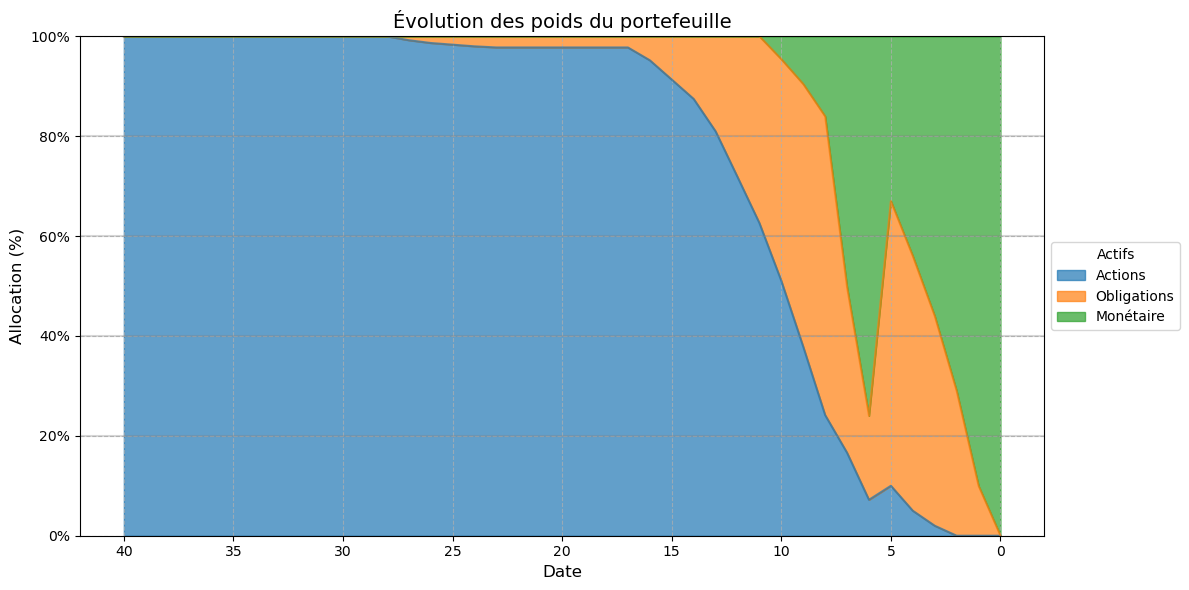

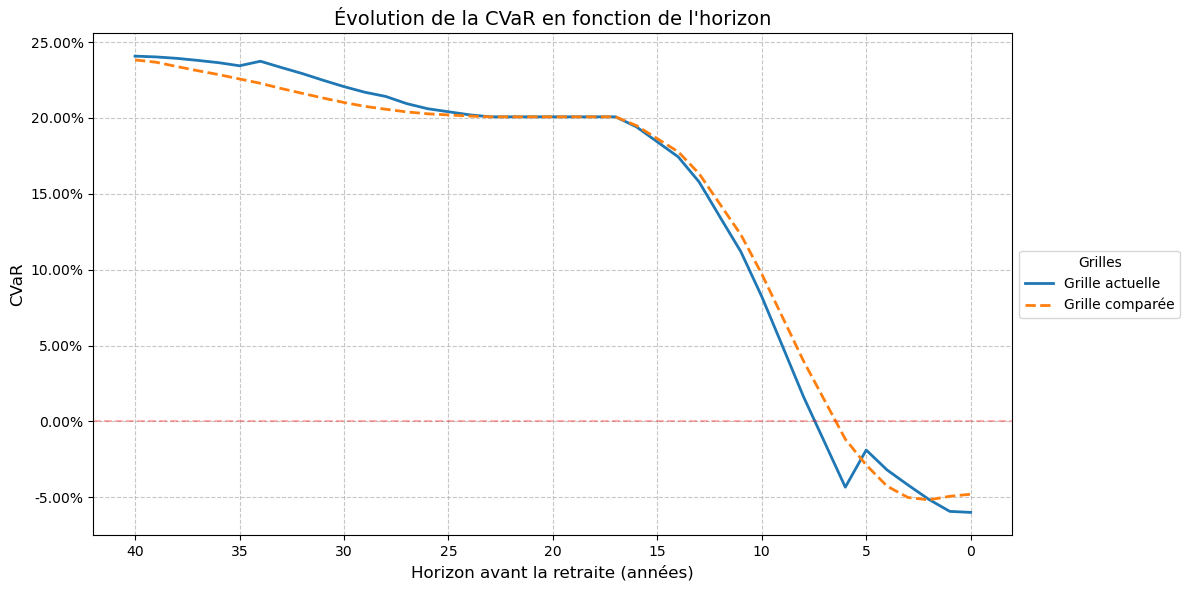

In [ ]:
new_grid = Grid([0.07, 0.04, 0.035], new_pilars_returns, "monthly", initial_grid.grid_weights)
new_grid = new_grid.optimize_grid(initial_grid)
Visualisation.plot_weights(new_grid.grid_weights, invert_xaxis=True)
Visualisation.plot_CVaR(new_grid, compare_with=initial_grid)

### 2. Grille dynamique

<Axes: title={'center': 'Evolution de la CVaR : grille initiale'}, xlabel='Horizon avant la retraite (années)', ylabel='CVaR'>

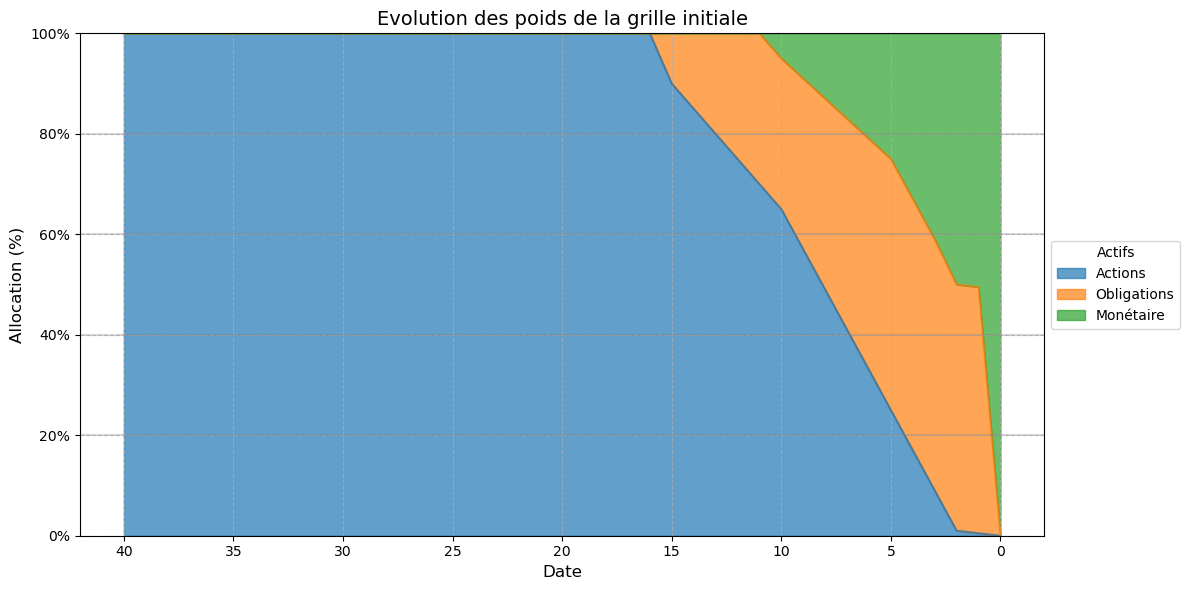

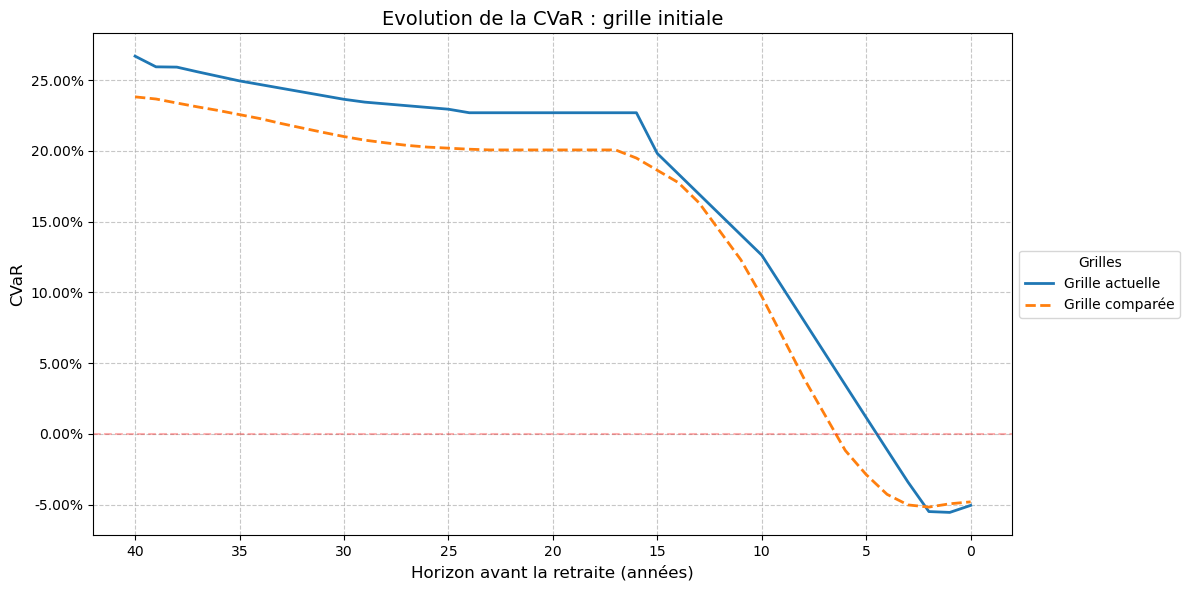

In [ ]:
initial_dynamic_grid_weights = pd.read_excel("data/Inputs.xlsx", sheet_name= "Grille dynamique").set_index("Horizon")
initial_dynamic_grid = Grid(
    long_term_returns=[0.06, 0.035, 0.02],
    portfolios_returns=initial_returns,
    periodicity=periodicity, 
    grid_weights=initial_dynamic_grid_weights
)
Visualisation.plot_weights(initial_dynamic_grid.grid_weights, 
                           title = "Evolution des poids de la grille initiale",
                           invert_xaxis= True)
Visualisation.plot_CVaR(grid = initial_dynamic_grid, compare_with=initial_grid,
                        title = "Evolution de la CVaR : grille initiale")